# CNN model

In [1]:
import torch
from torchtext import data
from torchtext import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np

from pathlib import Path
import time

import csv

# Check if we are running on a CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
!pip install stanza 
import stanza
stanza.download(lang='et')
stanza_nlp = stanza.Pipeline(lang='et', processors='tokenize')

2021-05-08 06:48:01 INFO: Downloading default packages for language: et (Estonian)...
2021-05-08 06:48:03 INFO: File exists: /root/stanza_resources/et/default.zip.
2021-05-08 06:48:05 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-05-08 06:48:05 INFO: Loading these models for language: et (Estonian):
| Processor | Package |
-----------------------
| tokenize  | edt     |

2021-05-08 06:48:05 INFO: Use device: cpu
2021-05-08 06:48:05 INFO: Loading: tokenize
2021-05-08 06:48:05 INFO: Done loading processors!


In [3]:
text = '''Keeletehnoloogia on arvutilingvistika praktiline pool.
Keeletehnoloogid kasutavad arvutilingvistikas välja töötatud
teooriaid, et luua rakendusi (nt arvutiprogramme),
mis võimaldavad inimkeelt arvuti abil töödelda ja mõista.

Tänapäeval on keeletehnoloogia tuntumateks valdkondadeks
masintõlge, arvutileksikoloogia, dialoogisüsteemid,
kõneanalüüs ja kõnesüntees.
'''
stanza_doc = stanza_nlp(text)
print([[token.text for token in stanza_doc.sentences[i].tokens] for i in range(len(stanza_doc.sentences))])


2021-05-08 06:31:48 INFO: Loading these models for language: et (Estonian):
| Processor | Package |
-----------------------
| tokenize  | edt     |

2021-05-08 06:31:48 INFO: Use device: cpu
2021-05-08 06:31:48 INFO: Loading: tokenize
2021-05-08 06:31:48 INFO: Done loading processors!


[['Keeletehnoloogia', 'on', 'arvutilingvistika', 'praktiline', 'pool', '.'], ['Keeletehnoloogid', 'kasutavad', 'arvutilingvistikas', 'välja', 'töötatud', 'teooriaid', ',', 'et', 'luua', 'rakendusi', '(', 'nt', 'arvutiprogramme', ')', ',', 'mis', 'võimaldavad', 'inimkeelt', 'arvuti', 'abil', 'töödelda', 'ja', 'mõista', '.'], ['Tänapäeval', 'on', 'keeletehnoloogia', 'tuntumateks', 'valdkondadeks', 'masintõlge', ',', 'arvutileksikoloogia', ',', 'dialoogisüsteemid', ',', 'kõneanalüüs', 'ja', 'kõnesüntees', '.']]


In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.et.300.vec.gz

--2021-05-08 06:31:52--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.et.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1209204423 (1.1G) [binary/octet-stream]
Saving to: ‘cc.et.300.vec.gz’

cc.et.300.vec.gz    100%[===================>]   1.13G  24.0MB/s    in 48s     

2021-05-08 06:32:41 (23.8 MB/s) - ‘cc.et.300.vec.gz’ saved [1209204423/1209204423]



In [5]:
!gunzip cc.et.300.vec.gz
!mkdir vector_cache/
!mv cc.et.300.vec vector_cache/

In [6]:
PAD = '<PAD>'
PAD_ID = 0
UNK = '<UNK>'
UNK_ID = 1

VOCAB_PREFIX = [PAD, UNK]

VEC_PATH = Path('vector_cache') / 'cc.et.300.vec'
DATA_PATH = Path('data')
MAX_VOCAB = 25000

batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed = 42

In [7]:
class PretrainedWordVocab:
    def __init__(self, data, lower=False):
        self.data = data
        self.lower = lower
        self.build_vocab()
        
    def normalize_unit(self, unit):
        if self.lower:
            return unit.lower()
        else:
            return unit
        
    def unit2id(self, unit):
        unit = self.normalize_unit(unit)
        if unit in self._unit2id:
            return self._unit2id[unit]
        else:
            return self._unit2id[UNK]
    
    def id2unit(self, id):
        return self._id2unit[id]
    
    def map(self, units):
        return [self.unit2id(unit) for unit in units]
        
    def build_vocab(self):
        # self._id2unit - id to unit (add PAD and UNK)
        # self._unit2id - unit to id 
        self._id2unit =  VOCAB_PREFIX + self.data
        self._unit2id = {w:i for i,w in enumerate(self._id2unit)}
        
    def __len__(self):
        return len(self._unit2id)

In [8]:
class Pretrain:
    def __init__(self, vec_filename, max_vocab=-1):
        self._vec_filename = vec_filename
        self._max_vocab = max_vocab
        
    @property
    def vocab(self):
        if not hasattr(self, '_vocab'):
            self._vocab, self._emb = self.read()
        return self._vocab
    
    @property
    def emb(self):
        if not hasattr(self, '_emb'):
            self._vocab, self._emb = self.read()
        return self._emb
        
    def read(self):
        if self._vec_filename is None:
            raise Exception("Vector file is not provided.")
        print(f"Reading pretrained vectors from {self._vec_filename}...")
        
        words, emb, failed = self.read_from_file(self._vec_filename, open_func=open)
        
        if failed > 0: # recover failure
            emb = emb[:-failed]
        if len(emb) - len(VOCAB_PREFIX) != len(words):
            raise Exception("Loaded number of vectors does not match number of words.")
            
        # Use a fixed vocab size
        if self._max_vocab > len(VOCAB_PREFIX) and self._max_vocab < len(words):
            words = words[:self._max_vocab - len(VOCAB_PREFIX)]
            emb = emb[:self._max_vocab]
                
        vocab = PretrainedWordVocab(words, lower=True)
        
        return vocab, emb
        
    def read_from_file(self, filename, open_func=open):
        """
        Open a vector file using the provided function and read from it.
        """
        first = True
        words = []
        failed = 0
        with open_func(filename, 'rb') as f:
            for i, line in enumerate(f):
                try:
                    line = line.decode()
                except UnicodeDecodeError:
                    failed += 1
                    continue
                if first:
                    # the first line contains the number of word vectors and the dimensionality
                    first = False
                    line = line.strip().split(' ')
                    rows, cols = [int(x) for x in line]
                    emb = np.zeros((rows + len(VOCAB_PREFIX), cols), dtype=np.float32)
                    continue

                line = line.rstrip().split(' ')
                emb[i+len(VOCAB_PREFIX)-1-failed, :] = [float(x) for x in line[-cols:]]
                words.append(' '.join(line[:-cols]))
        return words, emb, failed

In [24]:
class NewsDataSet(Dataset):
    def __init__(self, pretrain, data_folder='.data', test=False):
        self.pretrain_vocab = pretrain.vocab
        self.label_vocab = {'elu24': 0, 'err': 1, 'paevaleht': 2, 'postimees': 3, 'telegram': 4, 'uued_uudised': 5}
        self.delimiters =  {'elu24': ';', 'err': ',', 'paevaleht': ',', 'postimees': ';', 'telegram': ',', 'uued_uudised': ','}
        self.contents_idx = {'elu24': 1, 'err': 5, 'paevaleht': 3, 'postimees': 1, 'telegram': 3, 'uued_uudised': 3}
        self.data_folder = data_folder    
        self.data = []
        
        if self.data_folder.exists():
            self.load()
        else:
            raise ValueError("Data path doesn't exist!")
        
    def load(self):
        for label in ['err', 'paevaleht', 'telegram', 'uued_uudised']:
            print(f'Reading {label} articles...')
            filename = label + '.csv'
            p = self.data_folder / filename
            with open(p, 'r', encoding='utf-8') as f:
                csv_reader = csv.reader(f, delimiter=self.delimiters[label])
                next(csv_reader) # header
                for row in csv_reader:
                    try:
                        row = next(csv_reader)
                        contents = row[self.contents_idx[label]]
                        stanza_doc = stanza_nlp(contents)
                        tokenized = [[token.text for token in stanza_doc.sentences[i].tokens] for i in range(len(stanza_doc.sentences))]
                        flat_tokenized = flat_list = [item for sublist in tokenized for item in sublist]
                        self.data.append((self.pretrain_vocab.map(flat_tokenized), self.label_vocab[label]))
                    except:
                        continue
            print(self.data)
            # for fname in p.glob('*.txt'):
            #   with open(fname, 'r', encoding='utf-8') as f: 
            #     text = [ token.text for token in  tokenizer(f.readline()) ] 
            #   self.data.append((self.pretrain_vocab.map(text), self.label_vocab[label]))

                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
p = DATA_PATH / 'postimees.csv'
with open(p, 'r', encoding='utf-8') as f:
    for i in range(10):
        print(f.readline())

                }(document,"lb-script"""""," {""""liveblog_id"""":""""14846""""","options"""":{""""article_id"""":""""7193047""""","domain"""":""""www.postimees.ee""""}}));|Enne mängu:|Eesti esireket on seni esinenud ideaalilähedaselt. Avaringis alistas ta väga kindlalt tänavuse Austraalia lahtiste finalisti Jennifer Brady", eile polnud vastast endisest maailma edetabeli liidrist Angelique Kerberist. Mõlemad lahingud kestsid alla tunni. |Winners left, right & center <U+0001F929>Kontaveit powers into the #QatarTotalOpen2021 quarterfinals with a straight-sets win over Kerber! pic.twitter.com/p3Cn64kaoX— wta (@WTA) March 3, 2021||«Proovin lihtsalt hästi mängida ja end oma servil realiseerida. Kindlasti tuleb see kasuks, mida vähem ma väljakul viibin, seda värskem suudan olla järgmises kohtumises. Siiski ei saa seda oodata, et järgmised matšid võiksid sarnaselt kulgeda,» ütles Kontaveit pärast sakslanna alistamist.|Tugevatasemelisel turniiril ootab teda nüüd järjekordne kõva pähkel. Poolfi

In [25]:
pretrain = Pretrain(VEC_PATH, MAX_VOCAB)

In [27]:
def pad_sequences(batch):
  max_len = max([len(b[0]) for b in batch])

  padded_sequences = torch.zeros((len(batch), max_len), dtype=torch.long)
  labels = torch.zeros(len(batch), dtype=torch.float)

  for i, b in enumerate(batch):
    padded_sequences[i, :len(b[0])] = torch.LongTensor(b[0]) 
    labels[i] = b[1] 
  
  padded_sequences = padded_sequences.to(device)
  labels = labels.to(device)

  return padded_sequences, labels


In [26]:
data = NewsDataSet(pretrain, DATA_PATH)

Reading pretrained vectors from vector_cache/cc.et.300.vec...
Reading err articles...
[([1028, 1, 14806, 2218, 12862, 3306, 13353, 2821, 7237, 3, 1, 16948], 1), ([108, 1707, 5521, 7, 7551, 1, 1, 14274, 3526, 1864, 907, 5, 37, 3048, 7, 1, 1, 4505, 858, 1, 3096, 1098, 2, 2482, 1, 10188, 1, 11250, 17579, 14582, 3, 10700, 1, 1, 297, 997, 1, 2, 21, 4576, 2385, 1, 13559, 52, 1058, 7551, 3, 2748, 1, 21534, 6292, 6300, 4825, 3, 107, 2545, 7, 29, 2534, 449, 1, 5, 1, 1, 135, 2, 6193, 4221, 1, 1, 689, 1, 4453, 5, 1, 3412, 7596, 1, 1, 3, 2748, 1, 2702, 39, 5370, 1, 19, 16, 1, 3741, 4073, 3, 622, 403, 782, 19947, 30, 144, 10460, 1, 2039, 1, 2, 21, 7, 1190, 1, 1, 12349, 1, 1741, 876, 1, 3, 1, 1, 2545, 19, 23102, 2905, 14420, 2, 13, 124, 1, 1, 4326, 12858, 287, 1398, 14763, 8643, 17203, 2402, 3, 411, 7, 223, 1609, 1, 1, 2, 21, 199, 12, 468, 12539, 12, 8838, 1, 4326, 3, 1, 13804, 122, 1, 3, 2748, 1, 1, 34, 3646, 158, 1, 1, 5, 5370, 3, 29, 14, 1, 103, 113, 9137, 1, 2748, 2, 86, 16, 1, 4326, 1, 1, 5, 1,

In [28]:
# Creating data indices for training and validation splits:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [29]:
train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler, collate_fn=pad_sequences) 
validation_loader = DataLoader(data, batch_size=batch_size, sampler=valid_sampler, collate_fn=pad_sequences)
#test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=pad_sequences)

In [72]:
class CNN(nn.Module):
    def __init__(self, pretrain, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding.from_pretrained(
            torch.from_numpy(pretrain.emb), 
            padding_idx=pad_idx, 
            freeze=True
        )
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):           
        #text = [batch size, sent len]

        embedded = self.embedding(text)     
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)  
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]    
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]     
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        #return F.log_softmax(self.fc(cat), dim=1)
        return F.log_softmax(self.fc(cat), dim=1)

In [94]:
INPUT_DIM = len(pretrain.vocab)
EMBEDDING_DIM = pretrain.emb.shape[1]
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 6
DROPOUT = 0.5

model = CNN(pretrain, INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_ID)

In [95]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [113]:
def accuracy(preds, y): 
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(1).long()
    correct = (max_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [109]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
      optimizer.zero_grad()
      predictions = model(batch[0]).squeeze(1) 
      loss = criterion(predictions, batch[1].long())
      acc = accuracy(predictions, batch[1].long())
      loss.backward()
      optimizer.step()

      epoch_loss += loss 
      epoch_acc += acc 
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [115]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    preds = []
    golds = []

    with torch.no_grad():
      for batch in iterator: 
        predictions = model(batch[0]).squeeze(1)
        loss = criterion(predictions, batch[1].long())
        acc = accuracy(predictions, batch[1].long())
        epoch_loss += loss 
        epoch_acc += acc
        preds.extend(predictions.argmax(1).long())
        golds.extend(batch[1].long())
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, golds

In [56]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [116]:
N_EPOCHS = 5

best_valid_loss = float('inf')
final_preds = []
final_golds = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, preds, golds = evaluate(model, validation_loader, criterion)
    final_preds.extend(preds)
    final_golds.extend(golds)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'imdb_cnn_classifier.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 42s
	Train Loss: 1.315 | Train Acc: 41.05%
	 Val. Loss: 1.236 |  Val. Acc: 31.22%
Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 1.184 | Train Acc: 48.72%
	 Val. Loss: 1.115 |  Val. Acc: 46.24%
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 1.032 | Train Acc: 69.83%
	 Val. Loss: 1.002 |  Val. Acc: 68.00%
Epoch: 04 | Epoch Time: 0m 47s
	Train Loss: 0.945 | Train Acc: 79.83%
	 Val. Loss: 0.906 |  Val. Acc: 73.76%
Epoch: 05 | Epoch Time: 0m 47s
	Train Loss: 0.818 | Train Acc: 85.09%
	 Val. Loss: 0.839 |  Val. Acc: 75.95%


['err', 'paevaleht', 'telegram', 'uued_uudised']


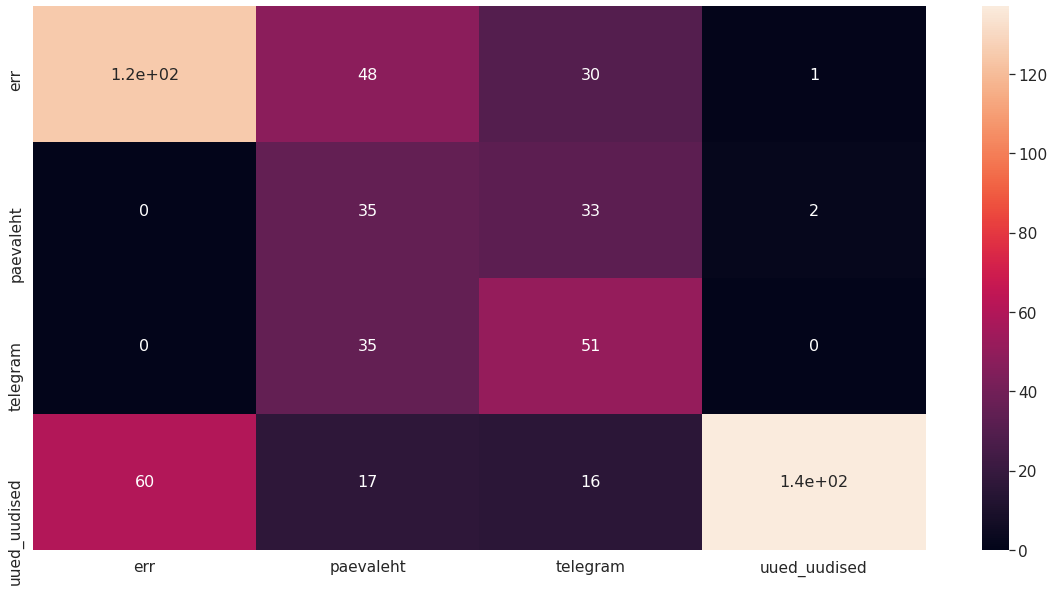

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

vocab = {0: 'elu24', 1 : 'err', 2 : 'paevaleht', 3 : 'postimees', 4 : 'telegram', 5: 'uued_uudised'}

preds = [vocab[i.item()] for i in final_preds]
golds = [vocab[i.item()] for i in final_golds]

labels = list(set(preds).union(set(golds)))

cm = confusion_matrix(preds, golds, labels=labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(20, 10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()